# **Analysis of the NTU RGB+D Action Recognition Dataset**

___
___

## **1. Initialization**

### *1.1. Import*

In [2]:
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns;

from torch.utils.data import Dataset

import torch

In [3]:
# to fill the requirement.txt file we use the following line of code:
import session_info
session_info.show()

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. Data Loading*

In [5]:
data2D_dir = "data/nturgbd60_skeletons_2D/"
data3D_dir = "data/nturgbd60_skeletons_3D/"

data2D_files = os.listdir(data2D_dir)
data3D_files = os.listdir(data3D_dir)

In [6]:
with open("data/actions.txt", 'r') as actions_file:
    actions = [line.replace('\n', '') for line in actions_file.readlines()]
    actions_file.close()

In [7]:
classes = [5, 6, 7, 8, 14, 24, 30, 32, 42]
for i,elem in enumerate(classes):
    print("class {} : {}".format(i, actions[elem]))

class 0 : pickup
class 1 : throw
class 2 : sitting down
class 3 : standing up (from sitting position)
class 4 : take off jacket
class 5 : reach into pocket
class 6 : pointing to something with finger
class 7 : check time (from watch)
class 8 : falling


In [8]:
class HumanActionDataset2D(Dataset):

    def __init__(self, data_dir, data_files, classes, with_depth=True, flatten=False):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.with_depth = with_depth
        self.flatten =  flatten

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if not self.with_depth:
            tensor = tensor[:,:,:2]
        if self.flatten:
            tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [9]:
class HumanActionDataset3D(Dataset):

    def __init__(self, data_dir, data_files, classes, flatten=False):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.flatten =  flatten

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if self.flatten:
            tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [10]:
HAD2D = HumanActionDataset2D(data2D_dir, data2D_files, classes, with_depth=False, flatten=False)
HAD3D = HumanActionDataset3D(data3D_dir, data3D_files, classes, flatten=False)

___

## **2. Analysis**

### *2.1. Number of Frames*

In [10]:
frames_info_2D = [(i, HAD2D[i][0].shape[0], HAD2D[i][1]) for i in range(len(HAD2D))]
frames_info_2D = pd.DataFrame(data=frames_info_2D, columns=["id", "nb_frames", "action_class"])
frames_info_2D = frames_info_2D.set_index("id")

In [11]:
frames_info_2D_stats = [frames_info_2D[frames_info_2D["action_class"] == i].describe()["nb_frames"] for i in range(len(classes))]
frames_info_2D_stats = pd.DataFrame(frames_info_2D_stats, index = range(len(classes)))

frames_info_2D_stats["count"] = frames_info_2D_stats["count"].astype(int)
frames_info_2D_stats["min"] = frames_info_2D_stats["min"].astype(int)
frames_info_2D_stats["25%"] = frames_info_2D_stats["25%"].astype(int)
frames_info_2D_stats["50%"] = frames_info_2D_stats["50%"].astype(int)
frames_info_2D_stats["75%"] = frames_info_2D_stats["75%"].astype(int)
frames_info_2D_stats["max"] = frames_info_2D_stats["max"].astype(int)
frames_info_2D_stats["mean"] = frames_info_2D_stats["mean"].round(2)
frames_info_2D_stats["std"] = frames_info_2D_stats["std"].round(2)

For a given action class:
* ***count**: number of sample*
* ***mean**: mean number of frames*
* ***std**: standard deviation*
* ***min**: minimum number of frames*
* ***25%**: 1st quartile for the number of frames*
* ***50%**: median number of frames*
* ***75%**: 3rd quartile for the number of frames*
* ***max**: maximum number of frames*

In [12]:
display(frames_info_2D_stats)

,count,mean,std,min,25%,50%,75%,max
0,943,81.36,13.54,54,72,81,90,131
1,944,63.77,12.51,37,55,62,71,136
2,941,74.24,13.97,46,65,74,83,119
3,936,63.59,11.72,39,55,63,71,120
4,945,140.91,33.88,66,117,138,159,277
5,946,97.42,23.20,54,82,94,109,202
6,944,56.10,11.57,32,48,54,63,110
7,946,63.82,14.16,36,54,62,71,128
8,946,63.64,12.44,40,56,62,70,139


### *2.2. Occupation of Space*

In this part we will see, for each action class, what part of the space is mostly used and where on the screen the action are most likely to be located.

In [24]:
# for a better visualization we will decrease the scale of the map by 10
heatmap2D = np.zeros((len(classes),25,192,108))

for i in range(len(HAD2D)):
    tensor2D,label2D = HAD2D[i]
    for j in range(tensor2D.shape[0]):
        for k in range(25):
            x = tensor2D[:,k,0][j].item()
            y = tensor2D[:,k,1][j].item()
            if np.isnan(x) or np.isnan(y):
                pass
            else:
                x = min(int(x/10),192)-1
                y = min(int(y/10),108)-1
                heatmap2D[label2D][k][x][y] += 1

<Figure size 432x288 with 0 Axes>

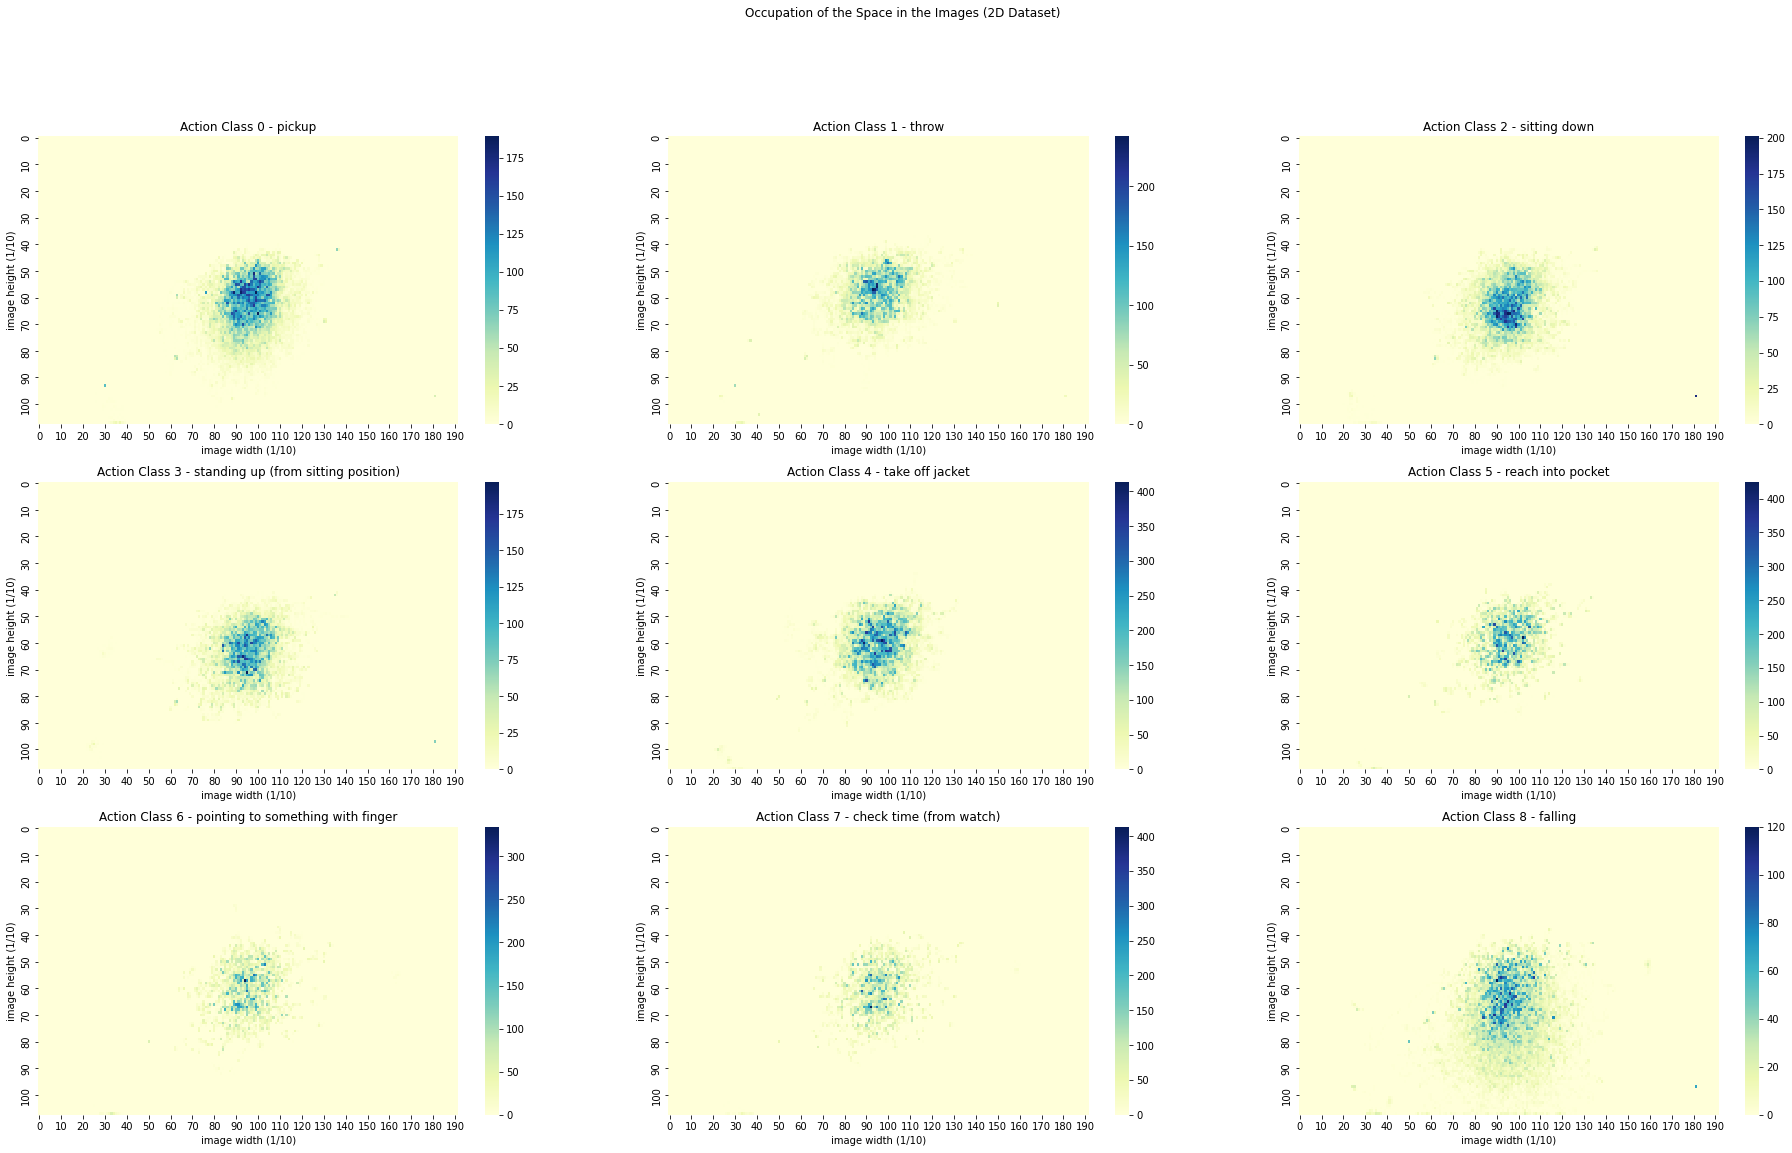

In [25]:
plt.clf()

fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(18)
fig.set_figwidth(32)

for i in range(len(classes)):

    ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
    h = sns.heatmap(heatmap2D[i][0].transpose(), cmap="YlGnBu", cbar=True, ax=ax[i//3][i%3], xticklabels=10, yticklabels=10)
    h.set_xlabel("image width (1/10)")
    h.set_ylabel("image height (1/10)")

fig.suptitle("Occupation of the Space in the Images (2D Dataset)")
plt.show()

In [35]:
distrib3D = [{"x": [], "y": [], "z": []} for i in range(len(classes))]

for i in range(len(HAD3D)):
    tensor3D,label3D = HAD3D[i]
    for j in range(tensor3D.shape[0]):
        for k in range(25):
            x = tensor3D[:,k,0][j].item()
            y = tensor3D[:,k,1][j].item()
            z = tensor3D[:,k,2][j].item()
            # to delete some outliers manually (we could have also considered the quantiles)
            if np.isnan(x) or np.isnan(y) or np.isnan(z) or (x < -2) or (y < -2) or (z < -2):
                pass
            else:
                distrib3D[label3D]["x"].append(x)
                distrib3D[label3D]["y"].append(y)
                distrib3D[label3D]["z"].append(z)

distrib3D_df = [pd.DataFrame(distrib3D[i]) for i in range(len(classes))]

<Figure size 432x288 with 0 Axes>

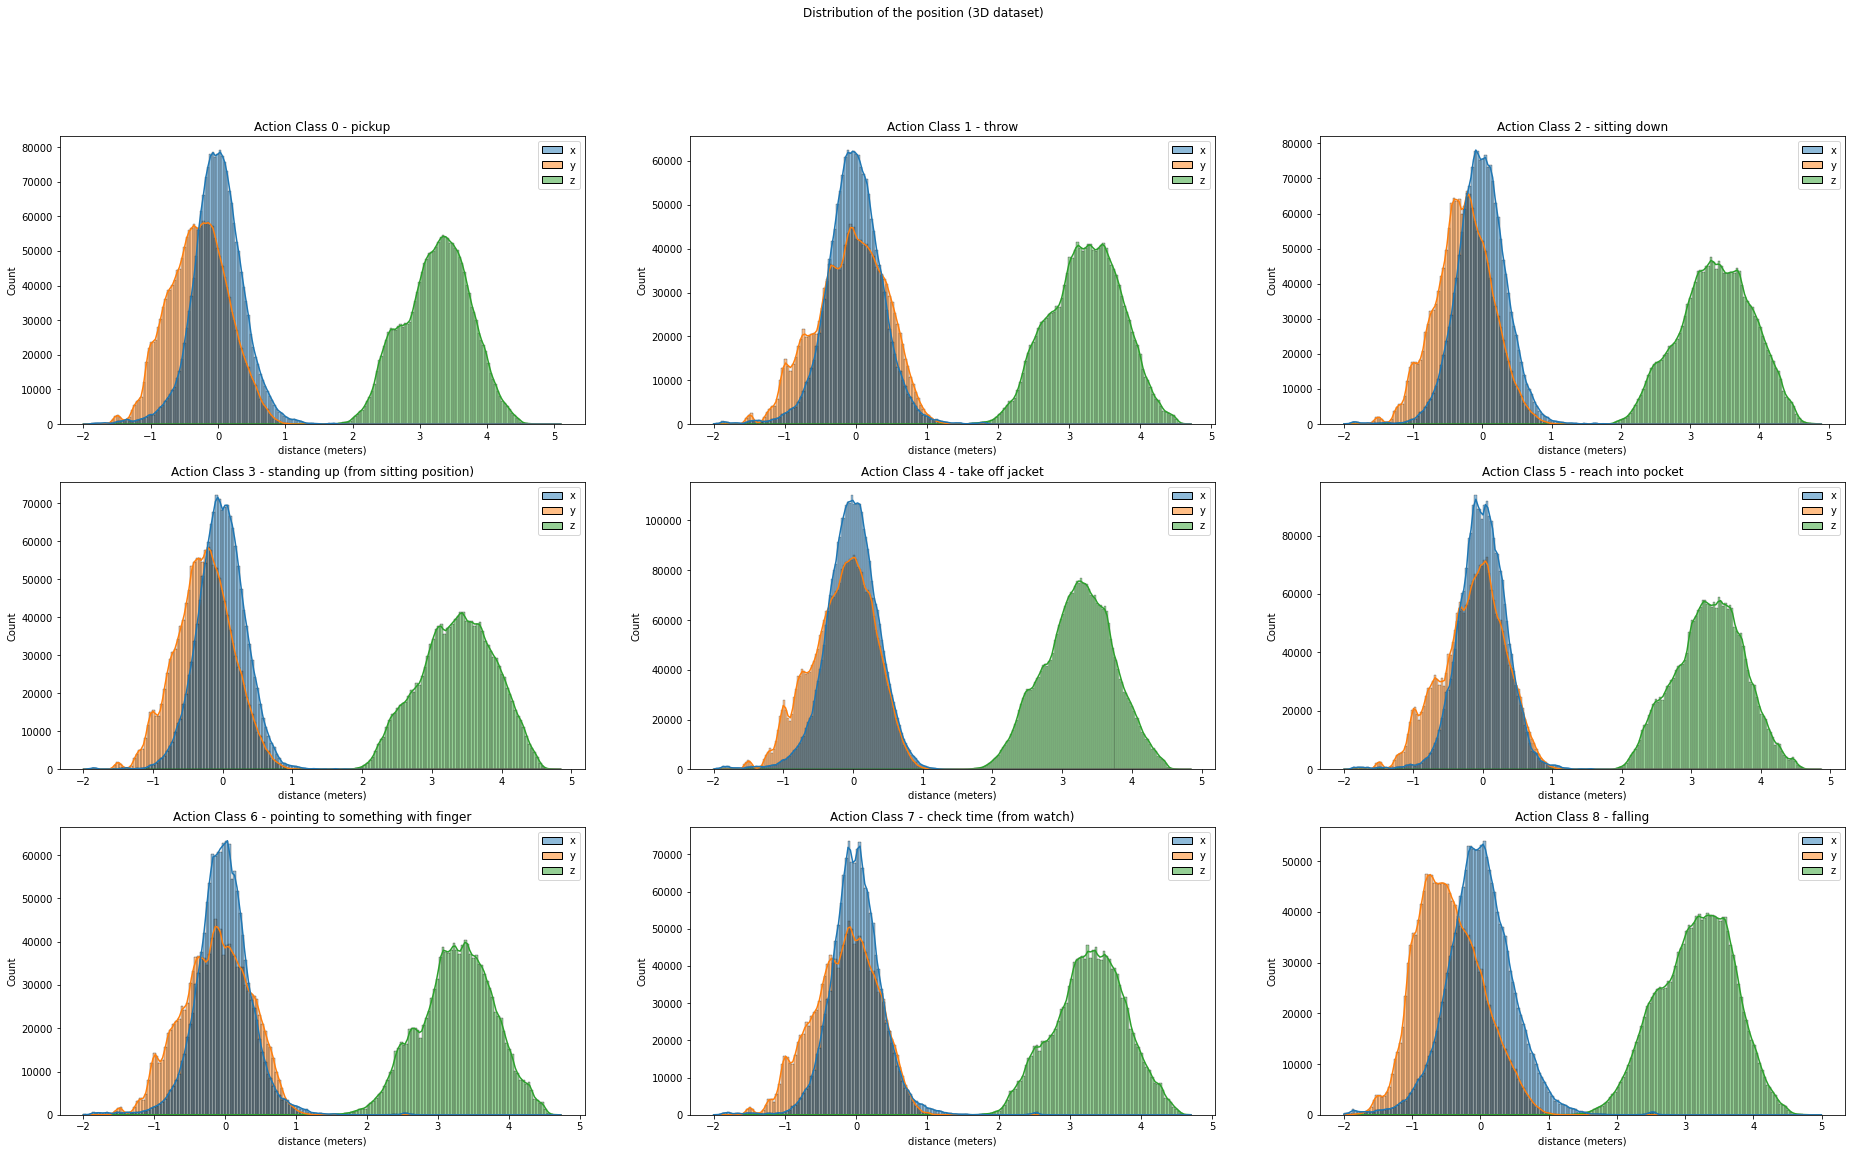

In [36]:
plt.clf()

fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(18)
fig.set_figwidth(32)

for i in range(len(classes)):

    ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
    h = sns.histplot(data=distrib3D_df[i], ax=ax[i//3][i%3], kde=True)
    h.set_xlabel("distance (meters)")

fig.suptitle("Distribution of the position (3D dataset)")
plt.show()

___
___